In [107]:
from PIL import Image
import numpy as np
!pip install --user pytesseract
!pip install --user opencv-python
!pip install --user tesseract
!pip install --user tensorflow
!pip install --user tensorflow_datasets
!pip install --user imutils
import pytesseract
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR/tesseract.exe'
from collections import namedtuple
import argparse
import imutils

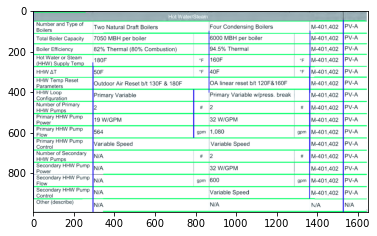

In [108]:
image1 = cv2.imread(cv2.samples.findFile('pictures/captureimage.png'))
image1 = cv2.resize(image1, None, fx=1.10, fy=1.10, interpolation=cv2.INTER_CUBIC)
#image1 = image1.astype("uint8")
kernel = np.ones((1, 1), np.uint8)
image1 = cv2.dilate(image1, kernel, iterations=10)
image1 = cv2.erode(image1, kernel, iterations=10)
cImage1 = np.copy(image1) #image to draw lines
cv2.imshow("test_text2.png", image1) #name the window as "image"
plt.imshow(image1)
plt.show()
cv2.waitKey(0)
cv2.destroyWindow("test_text2.png") #close the window

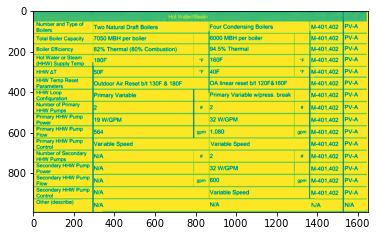

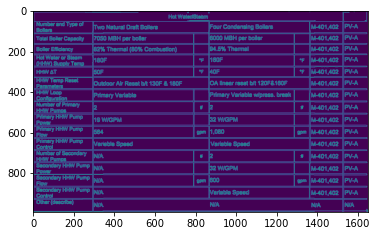

In [109]:
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
#gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cv2.imshow("gray", gray)
plt.imshow(gray)
plt.show()
cv2.waitKey(0)
cv2.destroyWindow("gray")
canny = cv2.Canny(gray, 50, 150)
cv2.imshow("canny", canny)
plt.imshow(canny)
plt.show()
cv2.waitKey(0)
cv2.destroyWindow("canny")

In [110]:
# cv.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) → lines
rho = 1
theta = np.pi/180
threshold = 50
minLinLength = 350
maxLineGap = 6
linesP = cv2.HoughLinesP(canny, rho , theta, threshold, None, minLinLength, maxLineGap)

In [111]:
def overlapping_filter(lines, sorting_index):
    filtered_lines = []
    
    lines = sorted(lines, key=lambda lines: lines[sorting_index])
    separation = 5
    for i in range(len(lines)):
            l_curr = lines[i]
            if(i>0):
                l_prev = lines[i-1]
                if ( (l_curr[sorting_index] - l_prev[sorting_index]) > separation):
                    filtered_lines.append(l_curr)
            else:
                filtered_lines.append(l_curr)
                
    return filtered_lines
def is_vertical(line):
    return line[0]==line[2]
def is_horizontal(line):
    return line[1]==line[3]

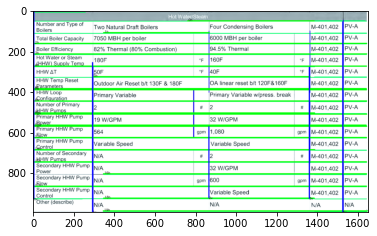

In [112]:
horizontal_lines = []
vertical_lines = []
    
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        if (is_vertical(l)): 
            vertical_lines.append(l)
                
        elif (is_horizontal(l)):
            horizontal_lines.append(l)
    horizontal_lines = overlapping_filter(horizontal_lines, 1)
    vertical_lines = overlapping_filter(vertical_lines, 0)
for i, line in enumerate(horizontal_lines):
    cv2.line(cImage1, (line[0], line[1]), (line[2], line[3]), (0,255,0), 3, cv2.LINE_AA)
    cv2.putText(cImage1, str(i) + "h", (line[0] + 5, line[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)                      
for i, line in enumerate(vertical_lines):
    cv2.line(cImage1, (line[0], line[1]), (line[2], line[3]), (0,0,255), 3, cv2.LINE_AA)
    cv2.putText(cImage1, str(i) + "v", (line[0], line[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)          
cv2.imshow("with_line", cImage1)
plt.imshow(cImage1)
plt.show()
cv2.waitKey(0)
cv2.destroyWindow("with_line") #close the window

In [113]:
## set keywords
keywords = ['col1','col2','col3','col4','col5'] 
dict1 = {}
for keyword in keywords:
  dict1[keyword] = []
## set counter for image indexing
counter = 0
    
## set line index
first_line_index = 0
last_line_index = 19
def get_cropped_image(image, x, y, w, h):
    cropped_image = image[ y:y+h , x:x+w ]
    return cropped_image
def get_ROI(image, horizontal, vertical, left_line_index, right_line_index, top_line_index, bottom_line_index, offset=4):
    x1 = vertical[left_line_index][2] + offset
    y1 = horizontal[top_line_index][3] + offset
    x2 = vertical[right_line_index][2] - offset
    y2 = horizontal[bottom_line_index][3] - offset
    
    w = x2 - x1
    h = y2 - y1
    
    cropped_image = get_cropped_image(image, x1, y1, w, h)
    
    return cropped_image, (x1, y1, w, h)

In [114]:
def draw_text(src, x, y, w, h, text):
    cFrame = np.copy(src)
    cv2.rectangle(cFrame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.putText(cFrame, "text: " + text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5, cv2.LINE_AA)
    
    return cFrame
def detect(cropped_frame, is_number = False):
    if (is_number):
        text = pytesseract.image_to_string(cropped_frame, lang='eng',
                                           config ='--psm 10')
    else:
        text = pytesseract.image_to_string(cropped_frame, lang='eng',
                                           config ='--psm 10')        
        
    return text
def invert_area(image, x, y, w, h, display=False):
    ones = np.copy(image)
    ones = 1
    
    image[ y:y+h , x:x+w ] = ones*255 - image[ y:y+h , x:x+w ] 
    
    if (display): 
        cv2.imshow("inverted", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return image

In [115]:
counter = 0
print("Start detecting text...")
(thresh, bw) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#left_line_index = 0
#right_line_index = 7
#top_line_index = 0
#bottom_line_index = -1
#cropped_image, (x, y, w, h) = get_ROI(image1, horizontal_lines, vertical_lines, left_line_index, right_line_index, top_line_index, bottom_line_index)
#bw = invert_area(bw, x, y, w, h, display=True)
for i in range(first_line_index, last_line_index):
    for j, keyword in enumerate(keywords):
        counter += 1
            
        left_line_index = j
        right_line_index = j+1
        top_line_index = i
        bottom_line_index = i+1
            
        cropped_image, (x,y,w,h) = get_ROI(bw, horizontal_lines, vertical_lines, left_line_index, right_line_index, top_line_index, bottom_line_index)
            
        if (keywords[j]=='col1'):
           text = detect(cropped_image)
           dict1[keyword].append(text)
         
        else:
            text = detect(cropped_image, is_number=True)
            dict1[keyword].append(text)
        image_with_text = draw_text(image1, x, y, w, h, text)

Start detecting text...


IndexError: list index out of range

In [ ]:
for info in dict1:
 curr=dict1.get(info);
 for i in range(len(curr)):
  curr[i]=curr[i].replace('\n','')
  if curr[i]=='Be'or curr[i]=='re' or curr[i]=='BS' or curr[i]=='Be':
    curr[i]=''
  if info=='spacearea':
   if ' ' in curr[i]:
    curr[i]=curr[i].replace(' ','.')
  #if info=='spacearea':
   #num=curr[i]
   #if num.count('.')==2:
   # num.replace('.',',',1)
   # curr[i]=num
  if info=='equipmentpowerdensity':
    curr[i]=curr[i].replace('O','0')
    curr[i]=curr[i].replace('WISE','W/SF')
 dict1[info]=curr
dict1

In [ ]:
newfile=pd.DataFrame.from_dict(dict1)
newfile.to_csv("output4.csv")

In [ ]:
pd.options.display.max_columns = None
df3 = pd.read_csv("output4.csv")
display(df3)